# Stock Market Predictor

In [87]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [88]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

In [89]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-01-19 00:00:00-05:00', '2024-01-22 00:00:00-05:00',
               '2024-01-23 00:00:00-05:00', '2024-01-24 00:00:00-05:00',
               '2024-01-25 00:00:00-05:00', '2024-01-26 00:00:00-05:00',
               '2024-01-29 00:00:00-05:00', '2024-01-30 00:00:00-05:00',
               '2024-01-31 00:00:00-05:00', '2024-02-01 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24137, freq=None)

<Axes: xlabel='Date'>

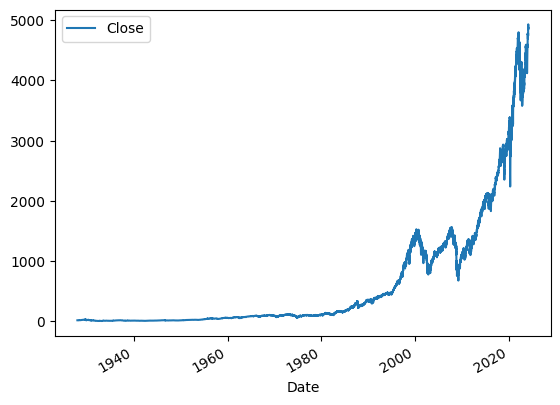

In [90]:
sp500.plot.line(y="Close", use_index=True)

In [91]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [92]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [93]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0


In [94]:
sp500 = sp500.loc["1990-01-01":].copy()

In [95]:
# Change N_ESTIMATORS so gain accuracy

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [96]:
preds = model.predict(test[predictors])

In [97]:
preds = pd.Series(preds, index=test.index)

In [98]:
precision_score(test["Target"], preds)

0.5490196078431373

<Axes: xlabel='Date'>

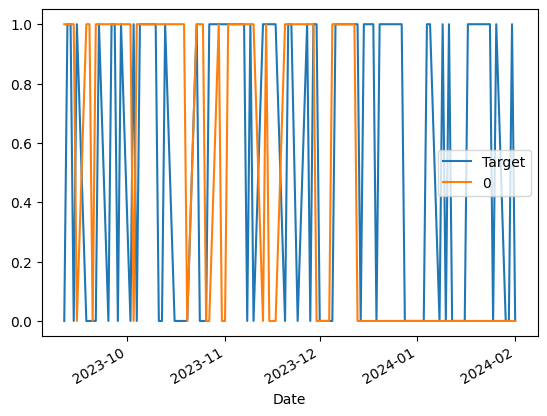

In [99]:
combined = pd.concat([test["Target"], preds], axis = 1)
combined.plot()

In [100]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [101]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [102]:
# predictions = backtest(sp500, model, predictors)

In [103]:
predictions["Predictions"].value_counts()

Predictions
0    3491
1    2596
Name: count, dtype: int64

In [104]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288906009244992

In [105]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.534582
0    0.465418
Name: count, dtype: float64

#### From this, we would have actually done better just buying at start of day and selling at end of day each day over using this model!! - so far....

going to look at the market closing price 2 days ago, 5 days ago, 60 days ago and so on...

In [106]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    # This is going to look at passed few days and see the sum of the target.
    
    new_predictors += [ratio_column, trend_column]

In [107]:
sp500 = sp500.dropna()

['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000']


In [108]:
# Increase n_estimators to 200 and decrease min_split to 50
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [109]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [110]:
predictions = backtest(sp500, model, new_predictors)

In [111]:
predictions["Predictions"].value_counts()

Predictions
0.0    4254
1.0     832
Name: count, dtype: int64

In [112]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5733173076923077

could think about, when there was a major up trend or fall, what was the news round the time, what was the general theme behind the stock price shift and was it straight away or 6 months away. Use this to help predict too.